In [32]:
import glob
from PIL import Image
import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt
from natsort import natsorted

import matplotlib
import matplotlib.patches as mpatches
import random
from scipy.ndimage import binary_fill_holes
from tqdm.notebook import tqdm

font = {'family' : 'Tahoma',
        'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)

# Phantoms

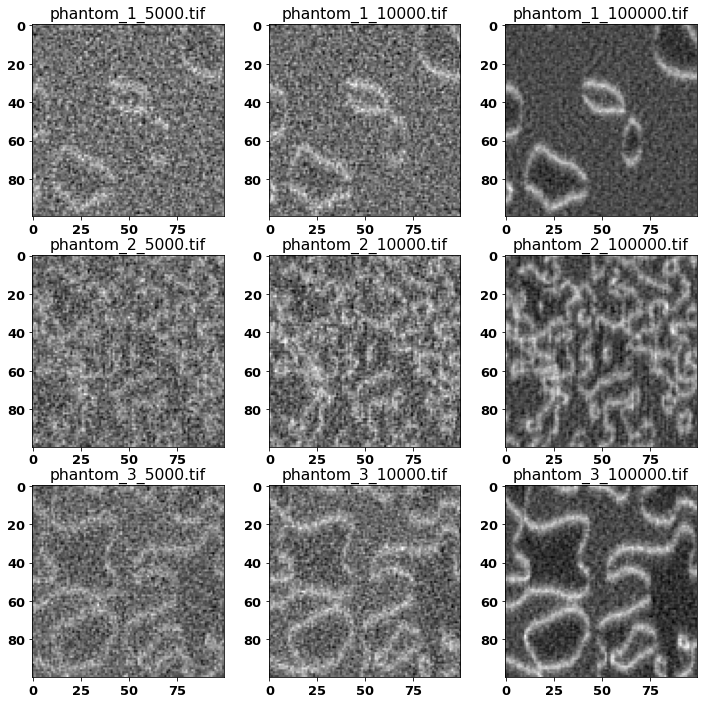

In [33]:
folder = "test_phantom/imgs"

crop = lambda img, ws=50: img[img.shape[0]//2-ws:img.shape[0]//2+ws, img.shape[1]//2-ws:img.shape[1]//2+ws]

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 12))
axes = axes.flatten()
img_paths = natsorted(glob.glob(f"{folder}/*.tif"))

for ax, path in zip(axes, img_paths):
    img = np.asarray(Image.open(path))

    title = path.split("/")[-1]
    ax.imshow(crop(img), cmap="gray")
    ax.set_title(title)

In [34]:
from skimage.filters import threshold_otsu

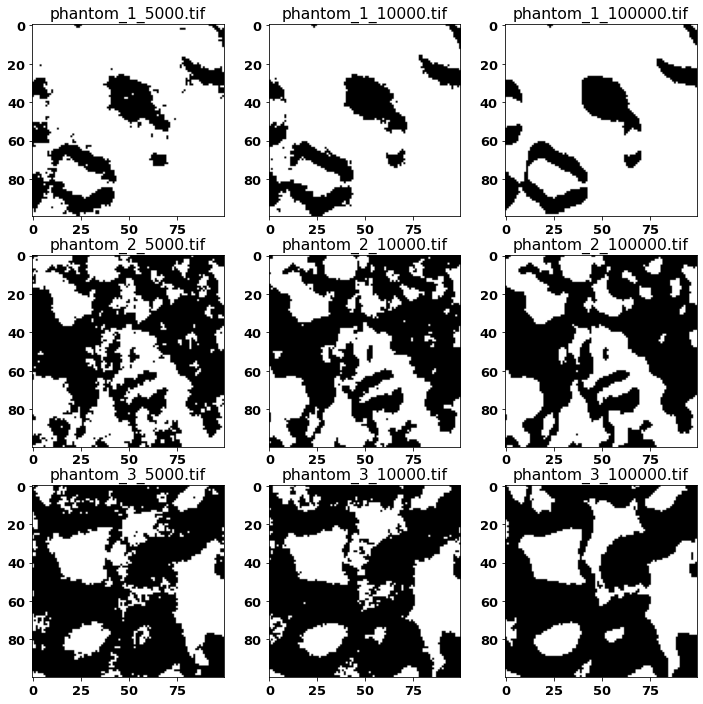

In [53]:
def poganins_correction(img, k=350, mu=0.1):
    data_fft = np.fft.fft2(img)

    freq = np.fft.fftfreq(img.shape[0])
    fx, fy = np.meshgrid(freq, freq)
    f2 = np.sqrt(fx**2+fy**2)

    data_corr_fft = data_fft/np.sqrt((k * f2**2+mu))
    data_corr = np.abs(np.fft.ifft2(data_corr_fft))

    return data_corr

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 12))
axes = axes.flatten()
img_paths = natsorted(glob.glob(f"{folder}/*.tif"))

for ax, path in zip(axes, img_paths):
    img = np.asarray(Image.open(path))

    title = path.split("/")[-1]

    poganin_img = poganins_correction(img)
    thrsh = threshold_otsu(poganin_img)

    # ax.hist(poganin_img.flatten(), bins=100)
    # ax.axvline(x=thrsh)
    ax.imshow(crop(poganin_img < thrsh), cmap="gray")
    # ax.imshow(crop(poganin_img > thrsh), cmap="Reds", alpha=0.3)
    ax.set_title(title)

# Real

## CNN vs Expert

In [7]:
input_images = "data/imgs_o/*.tif"
input_GT_masks = "data/masks_o/*.tif"
input_segmented_masks = "detection_sample_0_data/mask_binary_images/*.tif"


In [8]:
GT_mask_images = natsorted(glob.glob(input_GT_masks))
CNN_mask_images = natsorted(glob.glob(input_segmented_masks))
orig_images = natsorted(glob.glob(input_images))

In [9]:
image_names = list(zip(orig_images, GT_mask_images, CNN_mask_images))

def get_images(indx, image_names=image_names):
    orig, GT_mask, CNN_mask = image_names[indx]
    return {"orig": np.asarray(Image.open(orig)),
            "GT_mask": binary_fill_holes(np.asarray(Image.open(GT_mask))),
            "CNN_mask": np.asarray(Image.open(CNN_mask))}


def check_iou(img1, img2):
    img1, img2 = img1>0, img2>0
    return np.logical_and(img1, img2).sum() / np.logical_or(img1, img2).sum()

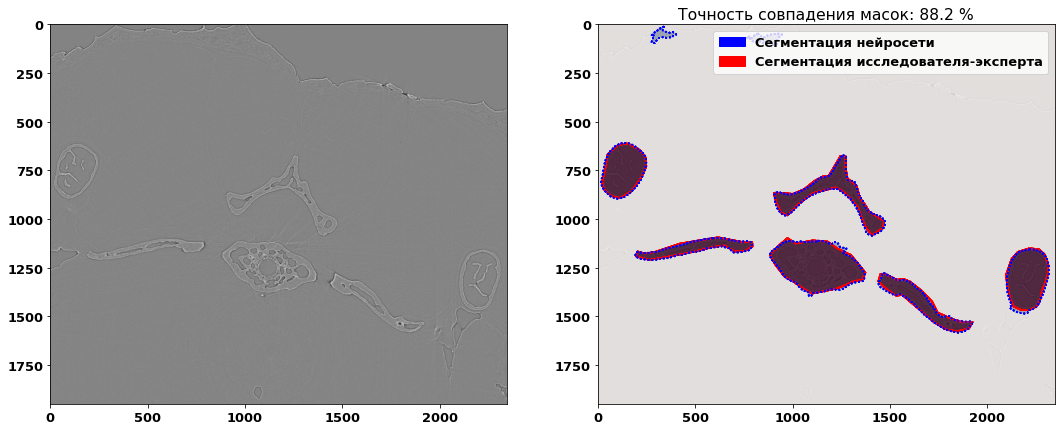

In [25]:
N_images = len(image_names)-1
r_index = random.randint(0, N_images)
_, axes = plt.subplots(ncols=2, figsize=(18, 9))

images = get_images(r_index)

axes[0].imshow(images["orig"], cmap="gray")

axes[1].imshow(images["orig"], cmap="gray")
axes[1].contour(images["GT_mask"], colors=['r'])
axes[1].imshow(images["GT_mask"], cmap='Reds', alpha=0.7)

axes[1].contour(images["CNN_mask"], colors=['b'], linestyles="dotted")
axes[1].imshow(images["CNN_mask"], cmap='Blues', alpha=0.3)

precision = check_iou(images["CNN_mask"], images["GT_mask"])
axes[1].set_title(f"Точность совпадения масок: {precision*100:.1f} %")


CNN_patch = mpatches.Patch(color='b', label="Сегментация нейросети")
GT_patch = mpatches.Patch(color='r', label="Сегментация исследователя-эксперта")
plt.legend(handles=[CNN_patch, GT_patch])
# shape = images[r_index][0].shape

In [16]:
precisions = []

for i in tqdm(range(N_images)):
    images = get_images(i)
    precisions.append(check_iou(images["CNN_mask"], images["GT_mask"]))

  0%|          | 0/199 [00:00<?, ?it/s]

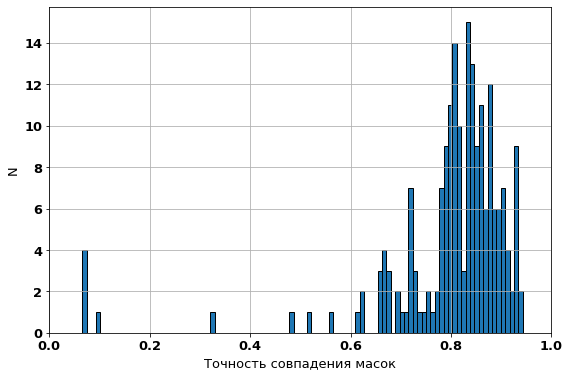

In [26]:
_, ax = plt.subplots(ncols=1, figsize=(9, 6))
ax.hist(precisions, bins=100, edgecolor='k')
ax.set_xlim([0, 1])
ax.set_xlabel("Точность совпадения масок")
ax.set_ylabel("N")
ax.grid()

# Train stats (open tensorboard)

In [55]:
import tensorboard.backend.event_processing.event_accumulator